In [ ]:
# simplify/ clean

# Policy gradient
In policy gradient, we parametrize directly the policy $\pi_\theta$. It's especially welcome when the action space is continuous; in that case greedy policy based on Q-learning need to compute the $argmax_a Q(s,a)$. This could be pretty tedious. More generally, policy gradient algorithms are better to explore large state-action spaces.

$J(\theta) 
= \sum_{s \in \mathcal{S}} d^\pi(s) V^\pi(s) 
= \sum_{s \in \mathcal{S}} d^\pi(s) \sum_{a \in \mathcal{A}} \pi_\theta(a \vert s) Q^\pi(s, a)$

In discrete action space

we parametrize $\pi$ with $\theta$, such as $\pi_\theta : S \rightarrow [0,1]^{dim(A)}$ and $\forall s$ $\sum \pi_\theta(s) = 1$.

In continous action space

we parametrize $\pi$ with $\theta$, such as $\pi_\theta : S \rightarrow \mu^{dim(A)} \times \sigma^{dim(A)} =  \mathbb{R}^{dim(A)} \times \mathbb{R}_{+,*}^{dim(A)}$



It is possible to show that the loss for discrete action ($1,...,N$) with softmax policy is weighted negative binary crossentropy:
$-G\sum_{j=1}^N[a^j\log(\hat{a}^j) + (1-a^j)\log(1 - \hat{a}^j)]$

with:
$a^j=1$ if $a_t = j$, $0$ otherwise.

$\hat{a}^j = \pi_\theta(s_t)^j$.

$G$ is the discounted empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$ from state $s_t$ and $a_t$


It is possible to show that the loss for conitnous action ($1,...,N$) with multivariate Gaussian (identity Covariance) policy is given by:

$-G\sum_{j=1}^N[(a^j - \hat{a}^j)^2]$

$\hat{a}^j = \pi_\theta(s_t)^j$.



see https://aleksispi.github.io/assets/pg_autodiff.pdf for more explanation

# Reinforce

In [1]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
from tools import discount_cumsum, run_experiment_episode_train

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

/home/raphael/rl_introduction/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
import tensorflow.keras.backend as K

In [5]:
class DeepAgent:                                                                                                                                                                                                
    def __init__(self, env, is_deterministic = False, gamma = .99, epsilon = .01):                                                                                                                          
        self.env = env                                                                                                                                                                                      
        self.is_deterministic = is_deterministic                                                                                                                                                            
        self.gamma = gamma                                                                                                                                                                                  
        self.epsilon = epsilon                                                                                                                                                                              
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
    def act(self, state):                                                                                                                                                                                   
        if self.is_deterministic:                                                                                                                                                                           
            action = np.argmax(self.policy[state])                                                                                                                                                          
        else:                                                                                                                                                                                               
            action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])                                                                                                              
            return action                                                                                                                                                                                       
        def train(current_state, action, reward, done):                                                                                                                                                         
            pass

In [6]:
import tensorflow.keras.backend as K

def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = K.sum(one_hot_action * K.log(action_probs) + (1 - one_hot_action) * K.log(1 - action_probs), axis=1)
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [8]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgent):
    def __init__(self, env, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .01, alpha = .01):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        
        self.model.summary()
        
        self.episode = []
        

    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(self.action_dim, activation='softmax')(x)
        model = Model(inputs=input_state, outputs=x)
        return model

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        if done is False:
            self.episode.append(np.array([current_state, action, reward]))
        else:
            episode = np.asarray(self.episode)
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            X = np.vstack(episode[:,0])
            Y = np.zeros((len(episode), self.action_dim))
            for i in range(len(episode)):
                Y[i, episode[i,1]] = 1
            loss = policy_gradient_loss(discounted_return)
            self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-3))
            self.model.train_on_batch(X,Y)
            self.episode = []

    def save_model(self, path):
        self.model.save(path)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 12.0
episode: 1 - cum reward 32.0
episode: 2 - cum reward 18.0
episode: 3 - cum reward 43.0
episode: 4 - cum reward 15.0
episode: 5 - cum reward 18.0
episode: 6 - cum reward 17.0
episode: 7 - cum reward 12.0
episode: 8 - cum reward 3

episode: 240 - cum reward 93.0
episode: 241 - cum reward 77.0
episode: 242 - cum reward 39.0
episode: 243 - cum reward 116.0
episode: 244 - cum reward 57.0
episode: 245 - cum reward 43.0
episode: 246 - cum reward 57.0
episode: 247 - cum reward 121.0
episode: 248 - cum reward 105.0
episode: 249 - cum reward 87.0
episode: 250 - cum reward 52.0
episode: 251 - cum reward 54.0
episode: 252 - cum reward 28.0
episode: 253 - cum reward 95.0
episode: 254 - cum reward 66.0
episode: 255 - cum reward 31.0
episode: 256 - cum reward 31.0
episode: 257 - cum reward 81.0
episode: 258 - cum reward 39.0
episode: 259 - cum reward 71.0
episode: 260 - cum reward 49.0
episode: 261 - cum reward 31.0
episode: 262 - cum reward 78.0
episode: 263 - cum reward 76.0
episode: 264 - cum reward 68.0
episode: 265 - cum reward 90.0
episode: 266 - cum reward 56.0
episode: 267 - cum reward 40.0
episode: 268 - cum reward 46.0
episode: 269 - cum reward 77.0
episode: 270 - cum reward 50.0
episode: 271 - cum reward 73.0
episo

episode: 502 - cum reward 45.0
episode: 503 - cum reward 48.0
episode: 504 - cum reward 60.0
episode: 505 - cum reward 51.0
episode: 506 - cum reward 57.0
episode: 507 - cum reward 87.0
episode: 508 - cum reward 56.0
episode: 509 - cum reward 137.0
episode: 510 - cum reward 59.0
episode: 511 - cum reward 67.0
episode: 512 - cum reward 61.0
episode: 513 - cum reward 51.0
episode: 514 - cum reward 73.0
episode: 515 - cum reward 40.0
episode: 516 - cum reward 55.0
episode: 517 - cum reward 28.0
episode: 518 - cum reward 50.0
episode: 519 - cum reward 54.0
episode: 520 - cum reward 54.0
episode: 521 - cum reward 35.0
episode: 522 - cum reward 49.0
episode: 523 - cum reward 76.0
episode: 524 - cum reward 47.0
episode: 525 - cum reward 37.0
episode: 526 - cum reward 70.0
episode: 527 - cum reward 59.0
episode: 528 - cum reward 75.0
episode: 529 - cum reward 53.0
episode: 530 - cum reward 54.0
episode: 531 - cum reward 87.0
episode: 532 - cum reward 53.0
episode: 533 - cum reward 49.0
episode

episode: 766 - cum reward 165.0
episode: 767 - cum reward 58.0
episode: 768 - cum reward 86.0
episode: 769 - cum reward 200.0
episode: 770 - cum reward 144.0
episode: 771 - cum reward 93.0
episode: 772 - cum reward 116.0
episode: 773 - cum reward 97.0
episode: 774 - cum reward 109.0
episode: 775 - cum reward 98.0
episode: 776 - cum reward 101.0
episode: 777 - cum reward 182.0
episode: 778 - cum reward 99.0
episode: 779 - cum reward 199.0
episode: 780 - cum reward 118.0
episode: 781 - cum reward 116.0
episode: 782 - cum reward 158.0
episode: 783 - cum reward 182.0
episode: 784 - cum reward 109.0
episode: 785 - cum reward 99.0
episode: 786 - cum reward 144.0
episode: 787 - cum reward 194.0
episode: 788 - cum reward 78.0
episode: 789 - cum reward 77.0
episode: 790 - cum reward 112.0
episode: 791 - cum reward 135.0
episode: 792 - cum reward 87.0
episode: 793 - cum reward 135.0
episode: 794 - cum reward 189.0
episode: 795 - cum reward 150.0
episode: 796 - cum reward 98.0
episode: 797 - cum 

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

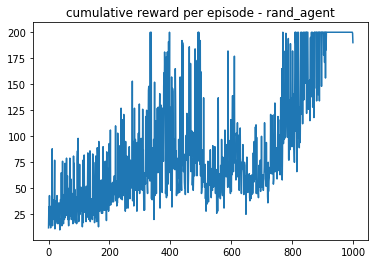

In [9]:
env = gym.make('CartPole-v0')
q_agent = ReinforceAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 1000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [13]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgent):
    def __init__(self, env, compiled_model = None, load_model_path = None, is_deterministic = False, gamma = .99, epsilon = .01, alpha = .01, memory_size = 10):
        super().__init__(env, is_deterministic, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        
        self.model.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        

    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(self.action_dim, activation='softmax')(x)
        model = Model(inputs=input_state, outputs=x)
        return model

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            X = np.vstack(episode[:,0])
            Y = np.zeros((len(episode), self.action_dim))
            Y[np.arange(len(episode)), episode[:,1].astype(int)] = 1
            if len(self.episodes) == self.memory_size:
                Xs = np.vstack([ep[0] for ep in self.episodes])
                Ys = np.vstack([ep[1] for ep in self.episodes])
                discounted_returns = np.hstack([ep[2] for ep in self.episodes])
                discounted_returns -= discounted_returns.mean()
                discounted_returns /= discounted_returns.std()
                self.episodes = []
                loss = policy_gradient_loss(discounted_returns)
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
                self.model.train_on_batch(Xs,Ys)
            else:
                self.episodes.append([X,Y,discounted_return])

    def save_model(self, path):
        self.model.save(path)

In [14]:
env = gym.make('LunarLander-v2')
q_agent = ReinforceAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 3000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 8)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 132       
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward -268.8412654535459
episode: 1 - cum reward -113.12021127235724
episode: 2 - cum reward -116.1844539

episode: 161 - cum reward -108.46569734286571
episode: 162 - cum reward -99.96610191344652
episode: 163 - cum reward -129.39988048305014
episode: 164 - cum reward -75.86576073306895
episode: 165 - cum reward -104.73067740933172
episode: 166 - cum reward -176.32629137509883
episode: 167 - cum reward -64.17937809118298
episode: 168 - cum reward -76.45213561743151
episode: 169 - cum reward -233.25625306987217
episode: 170 - cum reward -100.61542494362975
episode: 171 - cum reward -40.58368734630929
episode: 172 - cum reward -11.123344417079593
episode: 173 - cum reward -103.06997151661304
episode: 174 - cum reward -142.97723010833658
episode: 175 - cum reward -69.51344558607585
episode: 176 - cum reward -168.36488779186942
episode: 177 - cum reward -120.86024809392516
episode: 178 - cum reward -163.55681792380108
episode: 179 - cum reward -108.69246222011402
episode: 180 - cum reward -92.46567755852705
episode: 181 - cum reward -272.9446799145144
episode: 182 - cum reward -96.463305128312

episode: 342 - cum reward -49.19623264888864
episode: 343 - cum reward 54.34672084815142
episode: 344 - cum reward -317.96595259015123
episode: 345 - cum reward -333.4526209325495
episode: 346 - cum reward -18.96066273563325
episode: 347 - cum reward -363.01676660776775
episode: 348 - cum reward -350.4949814922088
episode: 349 - cum reward -253.51881354861845
episode: 350 - cum reward -17.10914776388725
episode: 351 - cum reward -121.33782164561478
episode: 352 - cum reward 5.825473791812271
episode: 353 - cum reward -4.13881988451854
episode: 354 - cum reward -1.4193480656794577
episode: 355 - cum reward -20.994640728506525
episode: 356 - cum reward -25.55827463267923
episode: 357 - cum reward -8.84546184411137
episode: 358 - cum reward 29.724428909986216
episode: 359 - cum reward -3.5573709377848246
episode: 360 - cum reward 41.67514180791943
episode: 361 - cum reward -4.953053056330845
episode: 362 - cum reward -17.277551049270798
episode: 363 - cum reward 3.981535003660113
episode:

episode: 525 - cum reward -36.174108614880325
episode: 526 - cum reward 8.406158102742708
episode: 527 - cum reward -59.809530931784174
episode: 528 - cum reward 49.87237347950451
episode: 529 - cum reward 42.55951135321149
episode: 530 - cum reward 68.54739978793768
episode: 531 - cum reward -20.433432189457562
episode: 532 - cum reward -13.3878570549345
episode: 533 - cum reward 57.36893145739251
episode: 534 - cum reward -14.878384834571875
episode: 535 - cum reward -14.438213737997387
episode: 536 - cum reward 19.061413977428394
episode: 537 - cum reward 7.8769426566482394
episode: 538 - cum reward 32.65669869987033
episode: 539 - cum reward -3.045198280812992
episode: 540 - cum reward -39.55084240998091
episode: 541 - cum reward -26.584734260952573
episode: 542 - cum reward -146.7259467582672
episode: 543 - cum reward -122.95647535807282
episode: 544 - cum reward -45.17865614927126
episode: 545 - cum reward 68.61366820786996
episode: 546 - cum reward -120.82565477387519
episode: 5

episode: 709 - cum reward -71.58539883598192
episode: 710 - cum reward -91.96944555584669
episode: 711 - cum reward -85.34270144674718
episode: 712 - cum reward -146.3331248371046
episode: 713 - cum reward -64.52467414067398
episode: 714 - cum reward -117.34270182136369
episode: 715 - cum reward -3.4651052475669104
episode: 716 - cum reward 40.2639570203207
episode: 717 - cum reward 204.9771769509137
episode: 718 - cum reward 158.41585722644157
episode: 719 - cum reward 32.60187446874957
episode: 720 - cum reward 116.31903096856837
episode: 721 - cum reward 88.06827942005972
episode: 722 - cum reward -35.660521093072646
episode: 723 - cum reward 52.093131092321876
episode: 724 - cum reward 160.65860039030667
episode: 725 - cum reward 211.33143392937833
episode: 726 - cum reward 0.9688393873173404
episode: 727 - cum reward -36.87800762088259
episode: 728 - cum reward -15.719578573035585
episode: 729 - cum reward -7.941936027423068
episode: 730 - cum reward -15.921705901413356
episode: 7

episode: 891 - cum reward 78.09546533092492
episode: 892 - cum reward 22.17163330216222
episode: 893 - cum reward -27.288840729445496
episode: 894 - cum reward 78.42196725279939
episode: 895 - cum reward 46.29298646526061
episode: 896 - cum reward 255.4286449387153
episode: 897 - cum reward -53.17089306443785
episode: 898 - cum reward 64.03840910312684
episode: 899 - cum reward 180.93908251820636
episode: 900 - cum reward 219.06301101998093
episode: 901 - cum reward 70.65720502464276
episode: 902 - cum reward -40.65825715746358
episode: 903 - cum reward -13.124504024209543
episode: 904 - cum reward -28.211000237532573
episode: 905 - cum reward 5.243415175256629
episode: 906 - cum reward 6.97858286464708
episode: 907 - cum reward -18.302437171335527
episode: 908 - cum reward -10.289227446734643
episode: 909 - cum reward -21.08812610670755
episode: 910 - cum reward 25.313848265693267
episode: 911 - cum reward -56.49861915419073
episode: 912 - cum reward 8.72764713981772
episode: 913 - cu

episode: 1073 - cum reward 6.579117631853109
episode: 1074 - cum reward -225.55419542872573
episode: 1075 - cum reward 223.8503666142091
episode: 1076 - cum reward 229.64417645478812
episode: 1077 - cum reward 22.30923886491024
episode: 1078 - cum reward 11.610334137282933
episode: 1079 - cum reward 68.65369096993282
episode: 1080 - cum reward 35.603989300188175
episode: 1081 - cum reward -74.68404786570352
episode: 1082 - cum reward 19.560998959132135
episode: 1083 - cum reward 13.70987338026066
episode: 1084 - cum reward 207.02831681073928
episode: 1085 - cum reward 31.545231039033382
episode: 1086 - cum reward -54.78981415383555
episode: 1087 - cum reward 14.68456923364684
episode: 1088 - cum reward -26.03410138484
episode: 1089 - cum reward 31.862261873545123
episode: 1090 - cum reward -43.786405462116036
episode: 1091 - cum reward 2.1910639590050636
episode: 1092 - cum reward 6.643867114161097
episode: 1093 - cum reward -25.149616245393332
episode: 1094 - cum reward 57.68883849462

episode: 1253 - cum reward 147.40485401830952
episode: 1254 - cum reward 32.833634186855505
episode: 1255 - cum reward 37.75475266874059
episode: 1256 - cum reward 29.54834799738424
episode: 1257 - cum reward 267.521604352532
episode: 1258 - cum reward 38.65086480210957
episode: 1259 - cum reward 223.3652650248814
episode: 1260 - cum reward 25.82026658392725
episode: 1261 - cum reward 43.33076045496273
episode: 1262 - cum reward 58.350256712932435
episode: 1263 - cum reward 38.41087520611134
episode: 1264 - cum reward 82.66659871974625
episode: 1265 - cum reward -37.804448362437554
episode: 1266 - cum reward -34.995209039814014
episode: 1267 - cum reward -21.280946767309658
episode: 1268 - cum reward -73.16828802368997
episode: 1269 - cum reward -82.47099883977931
episode: 1270 - cum reward -57.615007289423815
episode: 1271 - cum reward -16.31772402807664
episode: 1272 - cum reward -43.94922040192193
episode: 1273 - cum reward -10.602655683413644
episode: 1274 - cum reward -42.10025578

ValueError: probabilities contain NaN

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 38.0
episode: 1 - cum reward 17.0
episode: 2 - cum reward 17.0
episode: 3 - cum reward 16.0
episode: 4 - cum reward 12.0
episode: 5 - cum reward 27.0
episode: 6 - cum reward 43.0
episode: 7 - cum reward 14.0
episode: 8 - cum reward

episode: 235 - cum reward 200.0
episode: 236 - cum reward 200.0
episode: 237 - cum reward 200.0
episode: 238 - cum reward 200.0
episode: 239 - cum reward 200.0
episode: 240 - cum reward 139.0
episode: 241 - cum reward 150.0
episode: 242 - cum reward 152.0
episode: 243 - cum reward 147.0
episode: 244 - cum reward 175.0
episode: 245 - cum reward 191.0
episode: 246 - cum reward 196.0
episode: 247 - cum reward 191.0
episode: 248 - cum reward 191.0
episode: 249 - cum reward 188.0
episode: 250 - cum reward 111.0
episode: 251 - cum reward 105.0
episode: 252 - cum reward 113.0
episode: 253 - cum reward 120.0
episode: 254 - cum reward 122.0
episode: 255 - cum reward 158.0
episode: 256 - cum reward 200.0
episode: 257 - cum reward 195.0
episode: 258 - cum reward 192.0
episode: 259 - cum reward 178.0
episode: 260 - cum reward 153.0
episode: 261 - cum reward 200.0
episode: 262 - cum reward 177.0
episode: 263 - cum reward 200.0
episode: 264 - cum reward 200.0
episode: 265 - cum reward 200.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

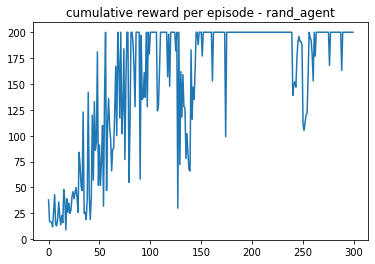

In [11]:
env = gym.make('CartPole-v0')
q_agent = ReinforceAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [58]:
def policy_gradient_loss_continuous(returns):
    def modified_mse(action_true, action_pred):
        loss = K.mean(returns * K.sum((action_true - action_pred)**2, axis=1))
        return loss
    return modified_mse

In [59]:
class DeepAgentContinuous:                                                                                                                                                                                                
    def __init__(self, env, gamma = .99, epsilon = .01):                                                                                                                          
        self.env = env                                                                                                                                                                                      
        self.gamma = gamma                                                                                                                                                                                  
        self.epsilon = epsilon                                                                                                                                                                              
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
    def act(self, state):                                                                                                                                                                                   
        pass
    def train(current_state, action, reward, done):                                                                                                                                                         
        pass 

In [64]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgentContinuous):
    def __init__(self, env, compiled_model = None, load_model_path = None, gamma = .99, epsilon = .01, alpha = .01, memory_size = 20):
        super().__init__(env, gamma, epsilon)
        
        if compiled_model is not None:
            self.model = compiled_model
        elif load_model_path is not None:
            self.model = load_model(load_model_path)
        else:
            self.model = self._build_model()
        
        self.model.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        

    def _build_model(self):
        input_state = Input(name='input_state', shape=(self.state_dim,), dtype='float32')
        input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
        x = Dense(32, activation='relu')(input_state)
        x = Dense(32, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(self.action_dim, activation='linear')(x)
        model = Model(inputs=input_state, outputs=x)
        return model

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.normal(prob)
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            X = np.vstack(episode[:,0])
            Y = np.vstack(episode[:,1])
            if len(self.episodes) == self.memory_size:
                Xs = np.vstack([ep[0] for ep in self.episodes])
                Ys = np.vstack([ep[1] for ep in self.episodes])
                discounted_returns = np.hstack([ep[2] for ep in self.episodes])
                self.episodes = []
                loss = policy_gradient_loss_continuous(discounted_returns)
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
                self.model.train_on_batch(Xs,Ys)
            else:
                self.episodes.append([X,Y,discounted_return])

    def save_model(self, path):
        self.model.save(path)

In [65]:
env = gym.make('LunarLanderContinuous-v2')
q_agent = ReinforceAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 3000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 8)]               0         
_________________________________________________________________
dense_52 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_53 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_54 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 66        
Total params: 2,466
Trainable params: 2,466
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward -552.2675132923471
episode: 1 - cum reward -80.50708098149488
episode: 2 - cum reward -510.5914101

episode: 162 - cum reward -181.6938050826386
episode: 163 - cum reward -476.4573650423432
episode: 164 - cum reward -209.6680519117425
episode: 165 - cum reward 27.66719993932091
episode: 166 - cum reward -174.07122044995418
episode: 167 - cum reward -156.27805049695021
episode: 168 - cum reward 0.13153003328838508
episode: 169 - cum reward -64.95019647333692
episode: 170 - cum reward -376.6783420200782
episode: 171 - cum reward -424.31348624297334
episode: 172 - cum reward -133.6289969813733
episode: 173 - cum reward -169.6982732763177
episode: 174 - cum reward -153.00535353055545
episode: 175 - cum reward -405.4639797239523
episode: 176 - cum reward -32.93313840722266
episode: 177 - cum reward -522.7000015712752
episode: 178 - cum reward -337.14061044113066
episode: 179 - cum reward -41.44888588466643
episode: 180 - cum reward -139.03657609969937
episode: 181 - cum reward -177.5892275368995
episode: 182 - cum reward -423.41184683540934
episode: 183 - cum reward -139.97095663075854
ep

episode: 343 - cum reward -93.97112949382763
episode: 344 - cum reward -125.0388569807206
episode: 345 - cum reward -133.91743621536
episode: 346 - cum reward -94.16251802491573
episode: 347 - cum reward -165.78497785486263
episode: 348 - cum reward -182.3729475379713
episode: 349 - cum reward -169.7230220673015
episode: 350 - cum reward -45.33392167853353
episode: 351 - cum reward -146.3441617901468
episode: 352 - cum reward -38.64986976017421
episode: 353 - cum reward -40.65116802874638
episode: 354 - cum reward -55.214723445038544
episode: 355 - cum reward -189.75758534232216
episode: 356 - cum reward -52.708078548900815
episode: 357 - cum reward -169.77956845850917
episode: 358 - cum reward -389.0520439221992
episode: 359 - cum reward -63.031440144064554
episode: 360 - cum reward -150.50558919764143
episode: 361 - cum reward -20.88592973086095
episode: 362 - cum reward 27.53652036581451
episode: 363 - cum reward -34.04020394158381
episode: 364 - cum reward -294.3989649392377
episod

episode: 524 - cum reward -19.69963389289515
episode: 525 - cum reward -88.31411246583173
episode: 526 - cum reward -162.21506361952328
episode: 527 - cum reward -95.35935049578706
episode: 528 - cum reward -100.25187374975319
episode: 529 - cum reward -250.59297238206813
episode: 530 - cum reward -72.07154337273299
episode: 531 - cum reward -98.10862444352412
episode: 532 - cum reward -67.8782291931031
episode: 533 - cum reward -119.03286875851691
episode: 534 - cum reward -105.00057514511879
episode: 535 - cum reward -130.50653758686448
episode: 536 - cum reward -106.56937239195476
episode: 537 - cum reward -128.10282883503302
episode: 538 - cum reward -112.84782908225255
episode: 539 - cum reward 23.180690724286407
episode: 540 - cum reward -155.9446294561555
episode: 541 - cum reward -156.36986049727054
episode: 542 - cum reward -215.05489193055485
episode: 543 - cum reward -172.75896361461403
episode: 544 - cum reward -76.11810242830168
episode: 545 - cum reward -113.8705507476318

episode: 706 - cum reward -47.52983279553353
episode: 707 - cum reward 8.563854982622445
episode: 708 - cum reward -37.814234481092626
episode: 709 - cum reward -31.596488369991377
episode: 710 - cum reward -146.28194293472404
episode: 711 - cum reward -148.81764601360393
episode: 712 - cum reward -195.5715488717112
episode: 713 - cum reward -108.38265529303322
episode: 714 - cum reward -135.2268299281437
episode: 715 - cum reward -153.35274901817542
episode: 716 - cum reward -322.9427141215838
episode: 717 - cum reward -32.83520397038295
episode: 718 - cum reward -142.18810632588998
episode: 719 - cum reward -190.8672013033493
episode: 720 - cum reward -4.5042221576541825
episode: 721 - cum reward -104.6543852823001
episode: 722 - cum reward -64.16007789113439
episode: 723 - cum reward -174.4223591255564
episode: 724 - cum reward -26.22772284645046
episode: 725 - cum reward 66.05596790006408
episode: 726 - cum reward -176.08189163706658


KeyboardInterrupt: 